In [0]:
#importing of necessary libraries and modules (recommended to run in Google colab)

!pip install mpnum
import numpy as np
import matplotlib.pyplot as plt
import mpnum as mp
import mpnum.povm as mpp
import functools
import scipy
from mpnum.utils.array_transforms import local_to_global
import os
import pickle
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':24})
rc('xtick', labelsize=24)
rc('ytick', labelsize=24)

import tensorflow as tf
import tensorflow.keras as K
import tensorflow_probability as tfp

from google.colab import drive
drive.mount('/content/gdrive')

'''we need to import TFI_processing,
thus, we go to the VAE_for_quantum_data
directory where the file is situated'''
%cd gdrive
%cd My Drive
%cd VAE_for_quantum_data

import TFI_processing as ising

# Here we define necessary functions for VAE building and training and tf graph for VAE

In [0]:
'''decoding data from z of size n to x of size N, number of hidden neurins - 
N_of_neurons'''
def decoder(N_of_neurons=512, N=12, n=10, name='decoder'):
    with tf.name_scope(name):
        # input data: z,h
        inp = K.Input(shape=(n+1,), dtype = tf.float32) 
        # hidden FC
        h1 = K.layers.Dense(N_of_neurons, activation=None, kernel_initializer='he_normal')(inp)
        a1 = K.layers.Activation('elu')(h1)
        # hidden FC
        h = K.layers.Dense(N_of_neurons, activation=None, kernel_initializer='he_normal')(a1)
        a = K.layers.Activation('elu')(h)
        # ouput
        out_= K.layers.Dense(N*4, activation=None, kernel_initializer='he_normal')(a)
        out = K.layers.Reshape((N, 4))(out_)
        model = K.Model(inputs=inp, outputs=out)
    return model

'''encoding data from x of size N to z of size n, number of hidden neurins -
N_of_neurons''' 
def encoder(N_of_neurons=512, N=12, n=10, name='encoder'):
    with tf.name_scope(name):
        # input data: x,h
        inp = K.Input(shape=(4*N+1,), dtype = tf.float32) 
        # hidden FC
        h1 = K.layers.Dense(N_of_neurons, activation=None, kernel_initializer='he_normal')(inp)
        a1 = K.layers.Activation('elu')(h1)
        # hidden FC
        h = K.layers.Dense(N_of_neurons, activation=None, kernel_initializer='he_normal')(a1)
        a = K.layers.Activation('elu')(h)
        # ouput
        out_= K.layers.Dense(n * 2, activation=None, kernel_initializer='he_normal')(a)
        out = K.layers.Reshape((n, 2))(out_) # miu - 1 row, ksi=2*log(sigma) - 2 row
        model = K.Model(inputs=inp, outputs=out)
    return model

'''calculation of cross-entropy: sum_ij {x_ij*logPi_ij}'''
def cross_entropy(logPi, x_true, name='cross_entropy'):
    with tf.name_scope(name):
        S = -logPi * x_true # x_true [batch,N,4] logPi [N,4]
        loss = tf.reduce_sum(tf.reduce_mean(S, axis=0)) #axis=0 - batch size
    return loss
  
'''calculation of KL divergence: -sum(sigma**2+miu**2-miu-1)/2'''
def KL_divergence(miu, ksi, name='KL_divergence'):
    with tf.name_scope(name):
        KL = 0.5 * (tf.exp(ksi) + miu ** 2 - ksi - 1) # ksi [batch,n], miu [batch,n]
        #reg1 = 0.5 * tf.reduce_sum((tf.exp(ksi) + miu ** 2), axis=-1)
        #reg2 = -0.5 * tf.reduce_sum(ksi + 1, axis=-1)
        loss = tf.reduce_sum(tf.reduce_mean(KL, axis=0))
    return loss  
  
'''splitting data set on batches'''
def batcher(x, h, batch_size):
    rng_state = np.random.get_state()
    np.random.shuffle(h)
    np.random.set_state(rng_state)
    np.random.shuffle(x)
    h_resh = h.reshape((-1, batch_size))
    x_resh = x.reshape((-1, batch_size) + x.shape[1:])
    return x_resh, h_resh 
  
'''train one epoch'''
def epoch_train(sess, x, h, batcher, learning_rate):
    x_batcher, h_batcher = batcher(x, h, batch_size)
    lss = []
    for i in range(h_batcher.shape[0]):
        l,_ = sess.run([loss, train], feed_dict={lr_p:learning_rate, x_p:x_batcher[i], h_p:h_batcher[i]})
        lss.append(l)
    return np.array(lss).mean()
  
# clear previous graphs
tf.reset_default_graph()

# hyperparameters
batch_size = 100000
sampling_size = 100000

n = 32 # size of hidden space
N = 32 # spins number


hidden_neurons = 256 # number of hidden neurons

# decoder/ encoder initialization
D=decoder(hidden_neurons, N, n)
E=encoder(hidden_neurons, N, n)

# epsilon for batches (Gaussian distribution)
eps = tf.random_normal(shape=(batch_size, n), name='eps')

# eps_s for sampling (Gaussian distribution)
eps_s = tf.random_normal(shape=(sampling_size, n), name='eps')

# placeholders
x_p = tf.placeholder(shape=(batch_size, N, 4),dtype=tf.float32,name='x_p') # spins
h_p = tf.placeholder(shape=(batch_size), dtype=tf.float32,name='h_p') # field
h_s = tf.placeholder(shape=(sampling_size), dtype=tf.float32,name='h_s') # field for sampling
lr_p = tf.placeholder(shape=(), dtype=tf.float32, name='lr_p') # learning rate

# extending x_p with h_p to state
x_data  = tf.concat([tf.reshape(x_p, shape=(-1, 4*N)), tf.reshape(h_p, shape=(-1, 1))], axis=-1)

# encoding data: x_data->hidden space
e_out = E(x_data)

# extracting miu and ksi=2log(sigma): e_out=[miu,ksi]
miu = e_out[:, :, 0]
ksi = e_out[:, :, 1]

# calculation hidden state
d_inp = eps * tf.sqrt(tf.exp(ksi)) + miu # hidden variables z=eps*sigma+miu - from Gaussian distributionfor Q

# extending d_inp with h_p
d_inp = tf.concat([tf.reshape(d_inp,shape=(-1, n)), tf.reshape(h_p, shape=(-1, 1))], axis=-1)

# softmax calculation of log(probabilities): to make Pi appropriate: sum(column)=1, all elements>=0
log_prob = tf.nn.log_softmax(D(d_inp), axis=-1)

# losses calculation
loss = cross_entropy(log_prob, x_p) + KL_divergence(miu, ksi)

# sampling log(probabilities) to obtain final probabilities matrix
sample_inp = tf.concat([tf.reshape(eps_s, shape=(-1,n)), tf.reshape(h_s, shape=(-1,1))], axis=-1)
sample_log_probs = tf.nn.log_softmax(D(sample_inp), axis=-1)

# optimizer
train = tf.train.AdamOptimizer(lr_p).minimize(loss)

################################################################################
################################################################################
################################################################################
################################################################################

#HERE IS THE PART OF TF. GRAPH WHICH ALLOWS TO CALCULATE DERIVATIVES OF MEAN
#VALUES WITH RESPECT TO EXTERNAL MAGNETIC FIELD

# sample from gumbel dist.
gumbel_dist = tfp.distributions.Gumbel(loc=0, scale=1)
gumbel_eps = gumbel_dist.sample([sampling_size, 32, 4])


# softmax temperature
Temp = tf.placeholder(shape=(), dtype=tf.float32, name="Temp")

# smoothed samples
logits = gumbel_eps + sample_log_probs
smoothed_samples = tf.nn.softmax(logits / Temp)


# tf version of inverse tetrahedral POVM
tf.M_inv = tf.constant(np.einsum('ij,jkl->ikl', ising.T_inv, ising.M), dtype=tf.complex64)

# stoch. estimation of dens. matrix
stoch_dens = tf.einsum('ijk,klm->ijlm', tf.cast(smoothed_samples, dtype=tf.complex64), tf.M_inv)

# stoch. estimation of magnetization along x
tf.sigma_x = tf.constant(ising.x, dtype=tf.complex64)
magn_x = tf.reduce_mean(tf.einsum('ijkl,lk->ij', stoch_dens, tf.sigma_x))
magn_x = tf.cast(magn_x, dtype=tf.float32)

# gradient of magn_x w.r.t h_x
der_magn_x = tf.gradients(magn_x, h_s)

# stoch. estimation of magnetization along z
tf.sigma_z = tf.constant(ising.z, dtype=tf.complex64)
magn_z = tf.reduce_mean(tf.einsum('ijkl,lk->ij', stoch_dens, tf.sigma_z))
magn_z = tf.cast(magn_z, dtype=tf.float32)

# gradient of magn_x w.r.t h_z
der_magn_z = tf.gradients(magn_z, h_s)

# Loading of a data

In [0]:
#The data set may be bigger than the RAM free space. In this case,
#one should be loaded dataset piecemeal during training 
#(in colab you can just require more RAM space)

h_load = np.load("data/H_values_N=" + str(N) + ".npy")
x_load = np.load("data/X_values_N=" + str(N) + ".npy")

#one hot representation of samples
x_load_OH = np.eye(np.max(x_load) + 1)[x_load]

# Training of VAE

In [0]:
#TF session and global variables initialization
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

#learning rate
in_lr = 0.001
#number of epochs
num_of_epochs = 500

losses = []

for i in range(num_of_epochs):
  
    #train one epoch
    l = epoch_train(sess, x_load_OH, h_load,batcher, in_lr)
    
    #append current loss
    losses.append(l)
    
    #plotting loss at each 10 epochs
    print(i)
    if i%10 == 0:
        fig = plt.figure(figsize=(15, 8))
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.plot(losses[-20:])
        plt.show()

# Saving of encoder and decoder weights

In [0]:
# sending sess to keras
tf.keras.backend.set_session(sess)

file_handler = open("encoder_decoder_weights/encoder_w_N=" + str(N) + ".npy", 'wb')
encoder_w = E.get_weights()

pickle.dump(encoder_w,file_handler)

file_handler = open("encoder_decoder_weights/decoder_w_N=" + str(N) + ".npy", 'wb')
decoder_w = D.get_weights()

pickle.dump(decoder_w,file_handler)

# Lodaing of encoder and decoder weights

In [0]:
# sending sess to keras
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
tf.keras.backend.set_session(sess)

file_handler = open("encoder_decoder_weights/encoder_w_N=" + str(N) + ".npy", 'rb')
encoder_w = pickle.load(file_handler)
E.set_weights(encoder_w)

file_handler = open("encoder_decoder_weights/decoder_w_N=" + str(N) + ".npy", 'rb')
decoder_w = pickle.load(file_handler)
D.set_weights(decoder_w)

# Sampling from VAE

In [0]:
# the list will be filled by models
models = []

# the list will be filled by samples
samples_learned = []

# the list will be filled by magnetic fields
fields_ = []

# number of magn fields
Ns = 21

# min magn field 
FieldMin = 0.0

# max magn field
FieldMax = 2.0

# step along magn. field
dField   = (FieldMax-FieldMin)/(Ns-1)

# loop over magn fields
for i in range(0, Ns):
    
    #current magn. field
    field = i * dField + FieldMin
    #loading corresponding MPS based mode
    filehandler = open("data/model_N=" + str(N) + "_h=" + str(round(field, 4)) + ".obj", 'rb')
    models.append(pickle.load(filehandler))
    # VAE
    h_s_inp = np.ones(sampling_size) * field
    probs = sess.run(sample_log_probs, feed_dict={h_s:h_s_inp})
    samples_learned.append((probs + np.random.gumbel(size=(probs.shape))).argmax(-1))
    fields_.append(field)
    
    print("---calculated field ",round(field, 4))

# Calculating and comparison numerical exact and VAE based magnetization

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


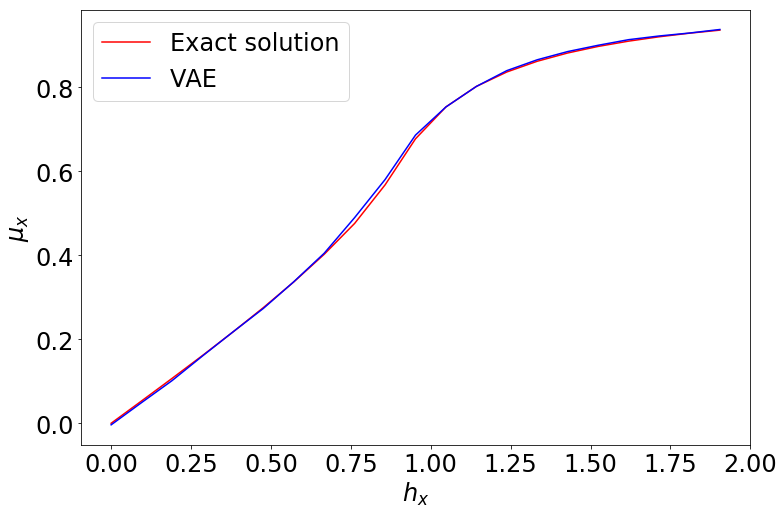

In [27]:
# numerical exact magnetization
magn = []

# magnetization calculated from VAE samples
magn_VAE = []

# the loop over magn. fields
for j in range(0, Ns):
    #initial zero fields
    spin = 0
    spin_VAE = 0
    
    #loop over spins
    for i in range(0,N):
        spin     = spin + models[j].one_site_mean(i+1, ising.x)
        spin_VAE = spin_VAE + ising.corr_from_samples(samples_learned[j], 1, i, ising.idm, ising.x)
        
    #adding magn. to the arrays
    magn.append(spin / N)
    magn_VAE.append(spin_VAE / N)
    
#plotting
fig = plt.figure(figsize=(12, 8))    
plt.plot(FieldMin + np.arange(Ns) * (FieldMax - FieldMin) / Ns, magn, 'r')
plt.plot(FieldMin + np.arange(Ns) * (FieldMax - FieldMin) / Ns, magn_VAE, 'b')
plt.xlabel(r'$h_x$')
plt.ylabel(r'$\mu_x$')
plt.legend(['Exact solution', 'VAE'])

# Plotting zz corr. func. and x mean value

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


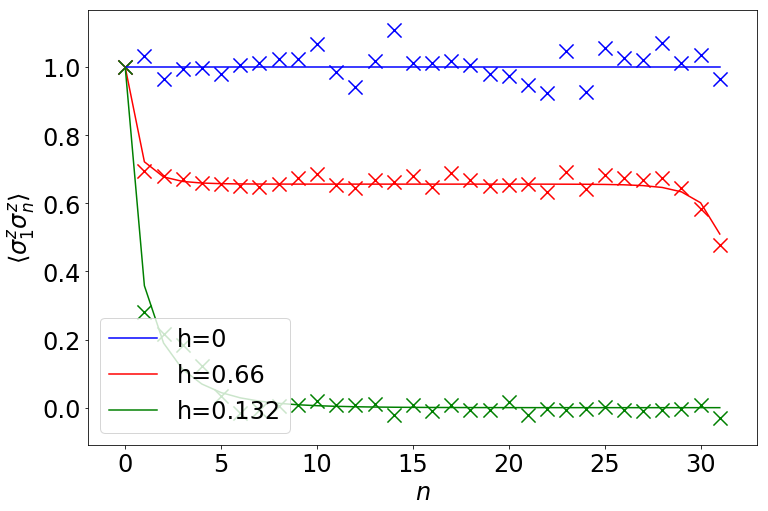

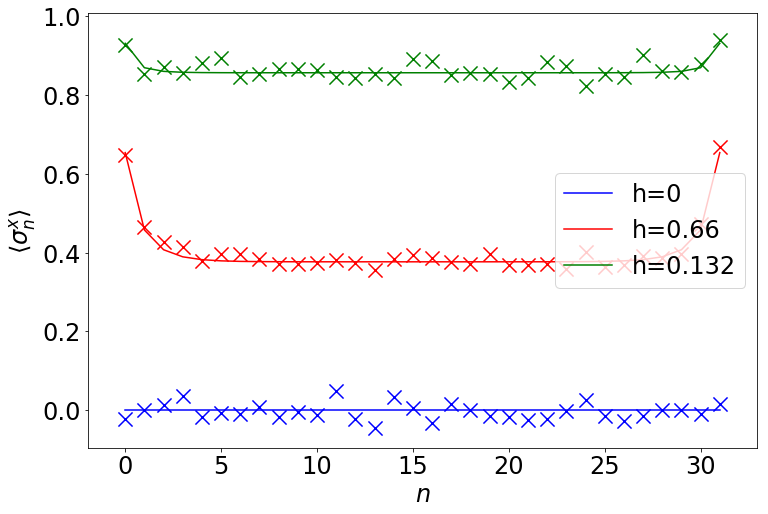

In [38]:
# the list will be filled by values of corr. func.
corr_exact = []
corr_VAE   = []

fig = plt.figure(figsize=(12, 8))

plt.plot([models[0].corr(1, i, ising.z, ising.z) for i in range(1, N+1)], 'b')
plt.scatter(np.arange(0, N), [ising.corr_from_samples(samples_learned[0], 1, i, ising.z, ising.z) for i in range(1, N+1)], marker='x', color='blue', s=200)

plt.plot([models[7].corr(1, i, ising.z, ising.z) for i in range(1, N+1)], 'r')
plt.scatter(np.arange(0, N), [ising.corr_from_samples(samples_learned[7], 1, i, ising.z, ising.z) for i in range(1, N+1)], marker='x', color='red', s=200)


plt.plot([models[14].corr(1, i, ising.z, ising.z) for i in range(1, N+1)], 'g')
plt.scatter(np.arange(0, N), [ising.corr_from_samples(samples_learned[14], 1, i, ising.z, ising.z) for i in range(1, N+1)], marker='x', color='green', s=200)

plt.ylabel(r'$\langle\sigma_1^z\sigma_n^z\rangle$')
plt.xlabel(r'$n$')
plt.legend(['h=0', 'h=0.66', 'h=0.132'])

fig = plt.figure(figsize=(12, 8))

plt.plot([models[0].corr(1, i, ising.idm, ising.x) for i in range(1, N+1)], 'b')
plt.scatter(np.arange(0, N), [ising.corr_from_samples(samples_learned[0], 1, i, ising.idm, ising.x) for i in range(1, N+1)], marker='x', color='blue', s=200)

plt.plot([models[7].corr(1, i, ising.idm, ising.x) for i in range(1, N+1)], 'r')
plt.scatter(np.arange(0, N), [ising.corr_from_samples(samples_learned[7], 1, i, ising.idm, ising.x) for i in range(1, N+1)], marker='x', color='red', s=200)


plt.plot([models[14].corr(1, i, ising.idm, ising.x) for i in range(1, N+1)], 'g')
plt.scatter(np.arange(0, N), [ising.corr_from_samples(samples_learned[14], 1, i, ising.idm, ising.x) for i in range(1, N+1)], marker='x', color='green', s=200)

plt.ylabel(r'$\langle\sigma_n^x\rangle$')
plt.xlabel(r'$n$')
plt.legend(['h=0', 'h=0.66', 'h=0.132'])

In [0]:
T_ = 0.001
res_x = []
res_num_x = []
res_z = []
res_num_z = []

for i in range(31):
  
    h_values_m = np.ones(sampling_size) * (0.5 + 0.05 * i - 0.01)
    h_values = np.ones(sampling_size) * (0.5 + 0.05 * i)
    h_values_p = np.ones(sampling_size) * (0.5 + 0.05 * i + 0.01)
    res_x.append(np.sum(sess.run(der_magn_x, feed_dict={h_s:h_values, Temp:T_})))
    res_num_x.append((sess.run(magn_x, feed_dict={h_s:h_values_p, Temp:T_}) - sess.run(magn_x, feed_dict={h_s:h_values_m, Temp:T_}))/0.02)
    res_z.append(np.sum(sess.run(der_magn_z, feed_dict={h_s:h_values, Temp:T_})))
    res_num_z.append((sess.run(magn_z, feed_dict={h_s:h_values_p, Temp:T_}) - sess.run(magn_z, feed_dict={h_s:h_values_m, Temp:T_}))/0.02)
    
fig = plt.figure(figsize=(12, 8))
plt.xlabel(r'$h$')
plt.ylabel(r'$\frac{\partial M_x}{\partial h}$')
plt.axis([0.5, 2.0, 0, 1.5])
plt.plot(np.arange(0, 31)*0.05+0.5, res_x, 'b')
plt.scatter(np.arange(0, 31)*0.05+0.5, res_num_x, marker='x', color='red', s=200)
plt.legend(['Exact', 'Numerical'])

fig = plt.figure(figsize=(12, 8))

plt.plot(np.arange(0, 31)*0.05+0.5, res_z, 'b')
plt.scatter(np.arange(0, 31)*0.05+0.5, res_num_z, marker='x', color='blue', s=200)
plt.legend(['Exact', 'Numerical'])